Adopted From: https://www.kaggle.com/code/srpatil/breast-cancer-classification-with-neural-network

In [1]:
# Import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns # data visualization library
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import torch
import torch.optim as optim
from torch import nn

In [2]:
# Get data
breast_cancer = load_breast_cancer()
df_breast_cancer = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names) # create a pandas DataFrame
df_breast_cancer['target'] = breast_cancer.target # add the target column to the DataFrame
df_breast_cancer.head() # now you can call head() on the DataFrame

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
# Data specification
'''
Attribute Information:

1) ID number
2) Diagnosis (M = malignant, B = benign)

3-32) Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed
for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is
Worst Radius.
'''

print(breast_cancer.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [4]:
# Split the data
breast_cancer = load_breast_cancer()
class_names = list(breast_cancer.target_names)
label_dict ={0: "malignant", 1: "benign"}  # labels 0 and 1 correspond to class names malignant and benign

X, y = breast_cancer.data, breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

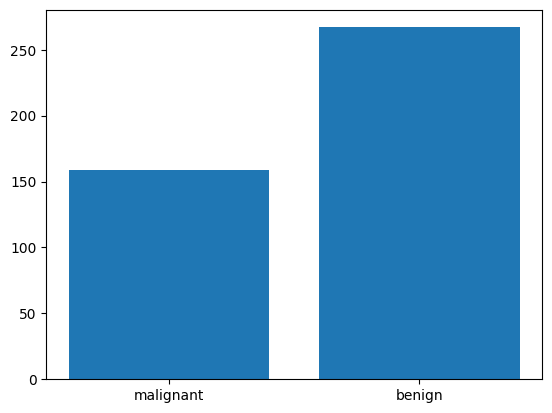

In [5]:
# Map with actual diagnosis
target_values, counts = np.unique(y_train, return_counts=True) # returns target values 0 and 1
diagnosis_labels = map(lambda x:label_dict[x],target_values)# map target value to diagnosis labels

plt.bar(list(diagnosis_labels), counts)
plt.show()

In [6]:
'''
In the data-set there are high possibilities for some features to be correlated. PCA is essentially a method that
reduces the dimension of the feature space in such a way that new variables are orthogonal to each other (i.e.
they are independent or not correlated).

From the cancer data-set we see that it has 30 features, so let’s reduce it to only 3 principal features and then
we can visualize the scatter plot of these new independent variables. Before applying PCA, we scale our data such
that each feature has unit variance. This is necessary because fitting algorithms highly depend on the scaling of
the features.
'''

# Normalizing the data
scaler = StandardScaler() #Instantiate the scaler

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

# Into zero mean and unit variance
print("After scaling minimum", X_train_scaled.mean(axis=0))

After scaling minimum [-3.38513776e-15 -1.09510731e-15  4.19278592e-15 -1.50427401e-15
 -2.20546064e-15 -3.77803227e-16  1.13967260e-15  4.94062277e-16
 -4.08906086e-15 -2.02837225e-15  2.18395985e-16 -3.18993658e-16
  2.86156075e-16 -6.48933176e-17  2.70128208e-15 -4.25976416e-16
  3.02053635e-16  3.92552449e-16  3.40624764e-16  1.28418403e-15
 -7.55785627e-17 -6.51539334e-17 -1.22306964e-15 -2.65828048e-17
  4.43864429e-15 -1.11022913e-15 -5.05464215e-16  1.10761687e-17
 -2.45083036e-15  2.71939487e-15]


shape of X_train_pca (426, 30)
shape of X_test_pca (143, 30)


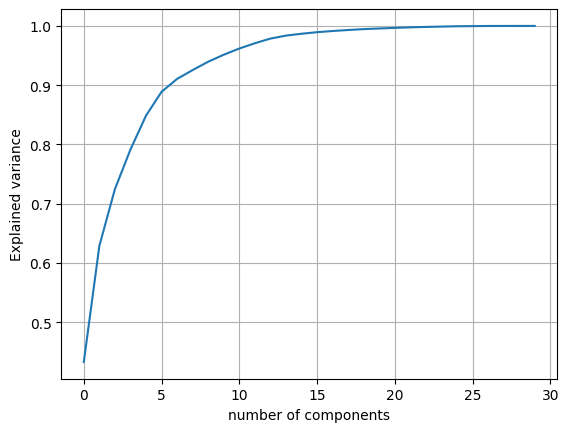

In [7]:
# Apply PCA
pca = PCA(n_components=30)
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

#let's check the shape of X_pca array
print("shape of X_train_pca", X_train_pca.shape)
print("shape of X_test_pca", X_test_pca.shape)

feature_variance = np.var(X_train_pca, axis=0)
normalized_variance = feature_variance/np.sum(feature_variance)

# Variance across the features
plt.plot(np.cumsum(normalized_variance))
plt.xlabel('number of components')
plt.ylabel('Explained variance')
plt.grid()
plt.show()

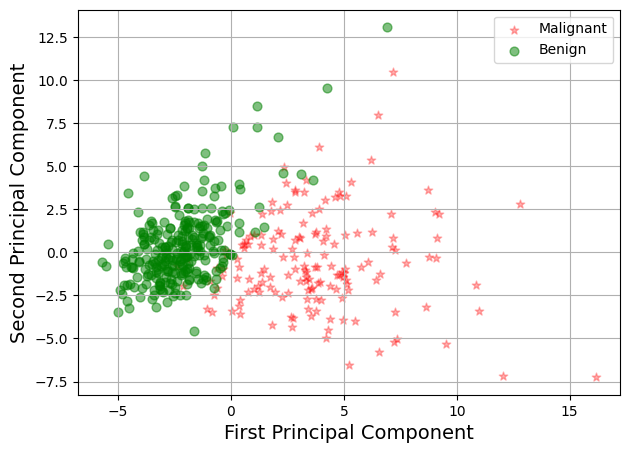

In [34]:
# Power of PCA

Xax = X_train_pca[:, 0]
Yax = X_train_pca[:, 1]
labels = y_train
cdict = {0: 'red', 1: 'green'}
labl = {0: 'Malignant', 1: 'Benign'}
marker = {0: '*', 1: 'o'}
alpha = {0: .3, 1: .5}
fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
    ix=np.where(labels==l)
    ax.scatter(Xax[ix], Yax[ix], c=cdict[l], s=40, label=labl[l], marker=marker[l], alpha=alpha[l])
# for loop ends
plt.xlabel("First Principal Component", fontsize=14)
plt.ylabel("Second Principal Component", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [9]:
# TODO: Create a MLP to classify this data
# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [28]:
# Convert data to tensors
dim_to_keep = 2
x_train = torch.tensor(X_train_pca[:, :dim_to_keep], dtype=torch.float32)
x_test = torch.tensor(X_test_pca[:, :dim_to_keep], dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

<ipython-input-28-7dfc10695461>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
<ipython-input-28-7dfc10695461>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long)


In [29]:
# Set hyperparameters
input_size = x_train.size(1)
hidden_size = 10
n_classes = 2
learning_rate = 0.01
n_epochs = 100

In [30]:
# Initialize the model, loss function, and optimizer
model = MLP(input_size, hidden_size, n_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
# Train the model
for epoch_idx in range(n_epochs):
    # Forward pass
    outputs = model(x_train)
    loss = loss_fn(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch_idx + 1) % 10 == 0:
        print(f'Epoch [{epoch_idx+1}/{n_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.5467
Epoch [20/100], Loss: 0.3093
Epoch [30/100], Loss: 0.1663
Epoch [40/100], Loss: 0.0938
Epoch [50/100], Loss: 0.0622
Epoch [60/100], Loss: 0.0475
Epoch [70/100], Loss: 0.0387
Epoch [80/100], Loss: 0.0327
Epoch [90/100], Loss: 0.0280
Epoch [100/100], Loss: 0.0243


In [32]:
# Test the model
with torch.no_grad():
    outputs = model(x_test)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    print(f'Accuracy on test set: {100*accuracy:.2f} %')

Accuracy on test set: 96.50 %


<Axes: >

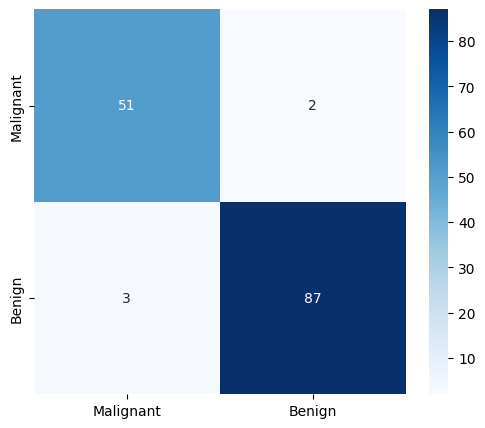

In [33]:
# See the confusion matrix
cm = confusion_matrix(y_test.numpy(), predicted.numpy())
labels = ['Malignant', 'Benign']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)